MCMC chain analysis
===========

In [1]:
%matplotlib inline
import numpy as np

The first thing we need to do is open the chain file.

In [2]:
raw = np.loadtxt('chain.dat');
shape = raw.size
print(shape)
    

40000


We know that the model has two parameters, so we need to reshape the chain, and find out how many steps were taken

In [3]:
save_dim = 2
num_steps = shape/(save_dim)
print(num_steps)

20000.0


Now we need to reshape the chain into something that we can use

In [4]:
chain = raw.reshape(num_steps,save_dim)
print(chain.shape)

(20000, 2)


/Users/davidparkinson/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


Now we can compute some summary statistics. Maybe we can look at the mean of the parameters

In [5]:
mean_x = np.mean(chain[:,0])
mean_y = np.mean(chain[:,1])
print("Mean (x) = {0:8.3f}, Mean (y) = {1:8.3f}".format(mean_x, mean_y))

Mean (x) =    0.121, Mean (y) =    1.450


And the standard deviations


In [6]:
var_x = np.var(chain[:,0])
var_y = np.var(chain[:,1])
print("Std dev (x) = {0:8.3f}, Std dev (y) = {1:8.3f}".format(np.sqrt(var_x), np.sqrt(var_y)))

Std dev (x) =    6.495, Std dev (y) =   13.028


The true best fit value for x and y are x=0.762 and y=-0.438556, and the errors on the two should be 0.12523 and 0.56687. What has gone wrong here?

Burn-in
------

The samples are meant to represent the distribution of probabilities for the parameters. But if the chain starts in a very low probability region, the initial chain elements will not be representative of the final distribution.

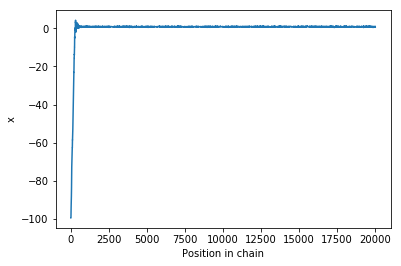

In [17]:
index = np.arange(0,num_steps)
import matplotlib.pyplot as plt
plt.plot(index,chain[:,0])
plt.xlabel('Position in chain')
plt.ylabel('x')

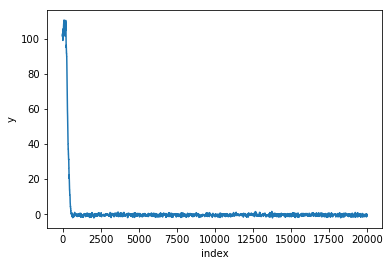

In [18]:
plt.plot(index,chain[:,1])
plt.xlabel('index')
plt.ylabel('y')

We see here that the first few hundred chain elements are composed of this 'burn-in' phase. We cut the first 1000 chain elements

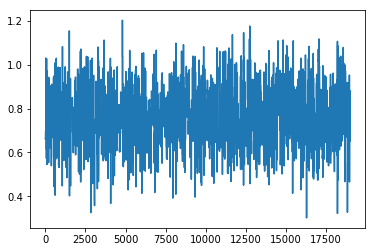

In [12]:
burn_in_index = 1000
burn_in_chain=chain[burn_in_index:,:]
burn_in_index=np.arange(0,num_steps-burn_in_index)
import matplotlib.pyplot as plt
plt.plot(burn_in_index,burn_in_chain[:,0])

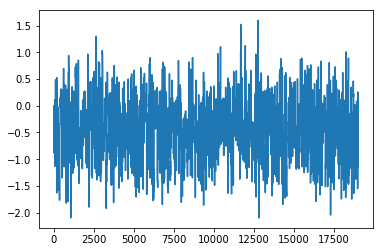

In [14]:
plt.plot(burn_in_index,burn_in_chain[:,1])

We now recompute the mean and variance

In [15]:
burn_in_mean_x = np.mean(burn_in_chain[:,0])
burn_in_mean_y = np.mean(burn_in_chain[:,1])
print("Mean (x) = {0:8.3f}, Mean (y) = {1:8.3f}".format(burn_in_mean_x, burn_in_mean_y))

Mean (x) =    0.767, Mean (y) =   -0.438


These values area much closer to the input model values of x = 0.762 and y = -0.438556,

In [19]:
burn_in_var_x = np.var(burn_in_chain[:,0])
burn_in_var_y = np.var(burn_in_chain[:,1])
print("Std dev (x) = {0:8.3f}, Std dev (y) = {1:8.3f}".format(np.sqrt(burn_in_var_x), np.sqrt(burn_in_var_y)))

Std dev (x) =    0.126, Std dev (y) =    0.550


These error values are much closer to the input values of errors, which are 0.12523 and 0.56687